In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from dataset import EEG
import wandb
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# Now do your import
from config import *

import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from mne.decoding import CSP
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

In [2]:
# home directory + datasets folder
#C:\Users\Pongk\Desktop\Work\mi-project\EEG-python\dataset\recorded_EEG
path = RECORED_PATH
#path = "/root/EEG_Model/dataset/finetune_EEG/"
#subject to run
runs = [2,3,4,6,8,12,15,17,18,22]
#runs = [4,6,8,10]  
#runs = [7,8,9,10]
subjects = [17]
#recorded eeg class
eeg = EEG(path, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter 
#iir_param = dict(order=5, ftype='butter', output='sos')
raw=raw.notch_filter([50])
#raw=raw.filter(8,14,method = 'iir',iir_params=iir_param,phase='zero')
raw.filter(8,13, method='fir', verbose=20)
print("Filter done")
#raw=eeg.raw_ica()
#eeg.create_epochs()
    

/Users/Pongk/Desktop/Work/mi-project/EEG-python/dataset/recorded_EEG


c:\Users\Pongk\Desktop\Work\mi-project\EEG-python\Training\dataset.py:53: RuntimeWarning: This filename (/Users/Pongk/Desktop/Work/mi-project/EEG-python/dataset/recorded_EEG\S017\S017R02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
c:\Users\Pongk\Desktop\Work\mi-project\EEG-python\Training\dataset.py:53: RuntimeWarning: This filename (/Users/Pongk/Desktop/Work/mi-project/EEG-python/dataset/recorded_EEG\S017\S017R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
c:\Users\Pon

Raw done
Filtering raw data in 10 contiguous segments
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition

In [3]:
#X = X[:, :,np.newaxis,:]
# X,y = eeg.raw_preprocess(raw)
epochs=eeg.epochs(raw,tmin=-3,tmax=5,baseline=(-3,0))
print(len(epochs.times))
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)
#(250*5)
#X = X[:,:,(250*3):]
#print(X.shape)
X = eeg.apply_CSP(X,y)
'''csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit_transform(X, y)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)'''
print(X.shape)
print(y)

400 events found
Event IDs: [1 2 3]
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 2001 original time points ...
0 bad epochs dropped
2001
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 3 dim * 5e+17  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 3 dim * 1.5e+16  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
(200, 3)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('Train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)
print(y_train)
print(y_test)

Train size (140, 3) (140,)
Test size (60, 3) (60,)
[1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0
 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1]
[0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0]


0.6142857142857143
Test acc:  0.43333333333333335


0.5666666666666667

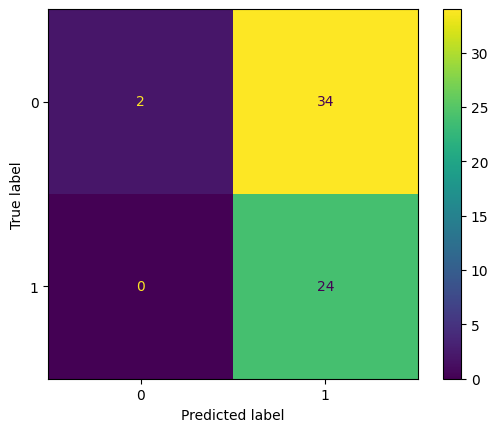

In [5]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Test acc: ", accuracy_score(y_test, y_pred))

pkl_filename = "svm_SO17_new_full.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)


confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
mean_squared_error(y_test, y_pred)

0.6285714285714286
Test acc:  0.4166666666666667


0.5833333333333334

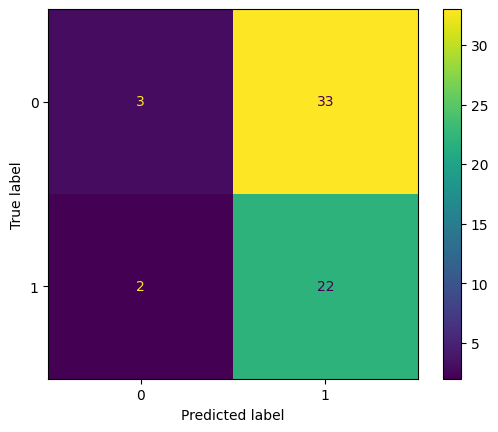

In [6]:
# train LDA classifier
lda = LDA()
lda.fit(X_train, y_train)
print(lda.score(X_train, y_train))
y_hat = lda.predict(X_test)

print("Test acc: ", accuracy_score(y_test, y_hat))
#save
pkl_filename = "lda_SO17_new_full.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lda, file)


confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
mean_squared_error(y_test, y_hat) 

1.0
Test acc:  0.43333333333333335


0.5666666666666667

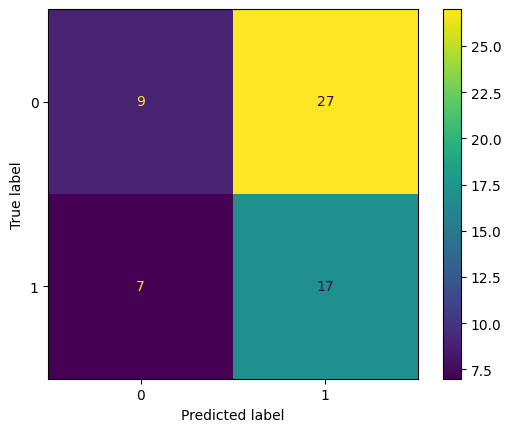

In [7]:
clf = RandomForestClassifier()
score = clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
y_hat = clf.predict(X_test)
print("Test acc: ", accuracy_score(y_test, y_hat))

pkl_filename = "forest_SO17_new_full.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)


confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
mean_squared_error(y_test, y_hat) 

In [8]:
# loaded_model = pickle.load(open('forest_SOO6_3-9.pk', 'rb'))
# y_hat = loaded_model.predict(X_test)
# print("Test acc: ", accuracy_score(y_test, y_hat))
# confusion_matrix(y_test, y_hat)
# ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
# mean_squared_error(y_test, y_hat) 
# #result = loaded_model.score(X_test, Y_test)